In [1]:
import numpy as np

primes = []
firstLine = True
with open("primes1.txt", 'r') as fobj:
    for line in fobj:
        if firstLine:
            firstLine = False
            continue
        numbers = [int(num) for num in line.split()]
        primes.extend(numbers)

primes = np.array(primes)
outputs = np.zeros(primes[-1]+1)
outputs[primes-1]=1
inputs = np.arange(1,len(outputs)+1)
print(inputs[:10], outputs[:10])
bit_count = 24
powersof2 = 1 << np.arange(bit_count).astype("uint32")
inputs_bits = ((inputs[:,None] & powersof2) > 0).astype(int)
np.dot(inputs_bits[-1],powersof2)==inputs[-1]

[ 1  2  3  4  5  6  7  8  9 10] [0. 1. 1. 0. 1. 0. 1. 0. 0. 0.]


True

In [2]:
from keras.layers import Input, Dense, BatchNormalization, Activation, Dropout
from keras.models import Model

inputValue = Input(shape=(bit_count,))
hidden = inputValue
for i in range(40):
    hidden = Dense(bit_count)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Activation("relu")(hidden)
    
for i in range(bit_count-1,2,-1):
    hidden = Dense(i)(hidden)
    hidden = BatchNormalization()(hidden)
    if i != 3:
        hidden = Activation("relu")(hidden)
    else:
        hidden = Activation("sigmoid")(hidden)
outputValue = Dense(1, activation='sigmoid')(hidden)
classifier = Model(inputValue, outputValue)
classifier.summary()

c:\users\edward\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
batch_normalization_1 (Batch (None, 24)                96        
_________________________________________________________________
activation_1 (Activation)    (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
batch_normalization_2 (Batch (None, 24)                96        
_________________________________________________________________
activation_2 (Activation)    (None, 24)                0         
__________

In [2]:
from sklearn.cross_validation import StratifiedShuffleSplit
stratSplit = StratifiedShuffleSplit(outputs, 1, test_size=0.01, random_state=42)
for train_idx,test_idx in stratSplit:
    X_train=inputs_bits[train_idx]
    Y_train=outputs[train_idx]
    X_test=inputs_bits[test_idx]
    Y_test=outputs[test_idx]    
len(X_train), len(Y_train),len(X_test),len(Y_test)

c:\users\edward\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(15331005, 15331005, 154859, 154859)

In [3]:
import keras.backend as K


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.

    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.

    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.

    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def f1(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.

    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

classifier.compile(optimizer='adam', loss="binary_crossentropy", metrics=[f1,precision,recall])

c:\users\edward\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
%matplotlib inline

from matplotlib import pyplot as plt
from IPython.display import clear_output
import keras

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.precision = []
        self.val_precision = []
        self.recall = []
        self.val_recall = []
        self.f1 = []
        self.val_f1 = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.precision.append(logs.get('precision'))
        self.val_precision.append(logs.get('val_precision'))
        self.recall.append(logs.get('recall'))
        self.val_recall.append(logs.get('val_recall'))
        self.f1.append(logs.get('f1'))
        self.val_f1.append(logs.get('val_f1'))
        self.i += 1
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=True, figsize=(17, 4))
        
        clear_output(wait=True)
        
        #ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="valdation loss")
        ax1.legend()
        
        ax2.plot(self.x, self.precision, label="precision")
        ax2.plot(self.x, self.val_precision, label="validation precision")
        ax2.legend()
        
        ax3.plot(self.x, self.recall, label="recall")
        ax3.plot(self.x, self.val_recall, label="validation recall")
        ax3.legend()

        ax4.plot(self.x, self.f1, label="f1")
        ax4.plot(self.x, self.val_f1, label="validation f1")
        ax4.legend()

        plt.show();
        
plot = PlotLearning()

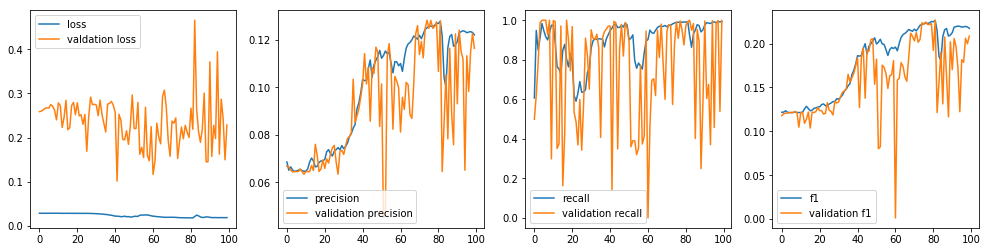

In [15]:
classifier.fit(X_train, Y_train,
                epochs=100,
                batch_size=65536,
                shuffle=True,
                validation_data=(X_test, Y_test),
                callbacks=[plot],
                class_weight={0: 0.06, 1: 0.94})

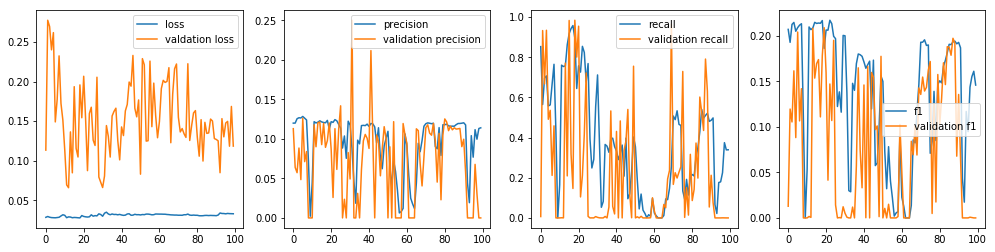

In [19]:
classifier.fit(X_train, Y_train,
                epochs=100,
                batch_size=65536,
                shuffle=True,
                validation_data=(X_test, Y_test),
                callbacks=[plot],
                class_weight={0: 0.11, 1: 0.89})

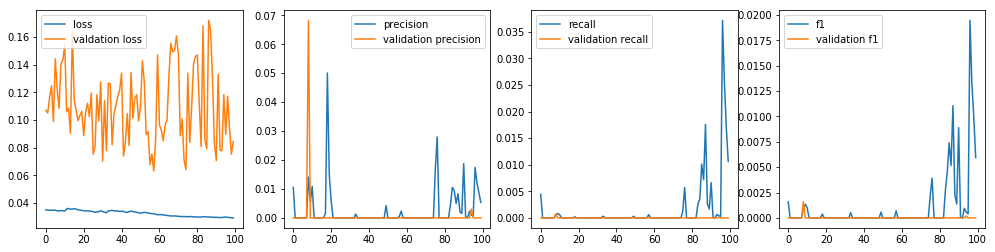

In [21]:
classifier.fit(X_train, Y_train,
                epochs=100,
                batch_size=65536,
                shuffle=True,
                validation_data=(X_test, Y_test),
                callbacks=[plot],
                class_weight={0: 0.132, 1: 0.868})

In [5]:
from keras.models import load_model
keras.metrics.f1 = f1
keras.metrics.precision = precision
keras.metrics.recall = recall
classifier = load_model('classifier_deeper')
optmzr = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
classifier.compile(optimizer=optmzr, loss="mean_squared_error", metrics=[f1,precision,recall])

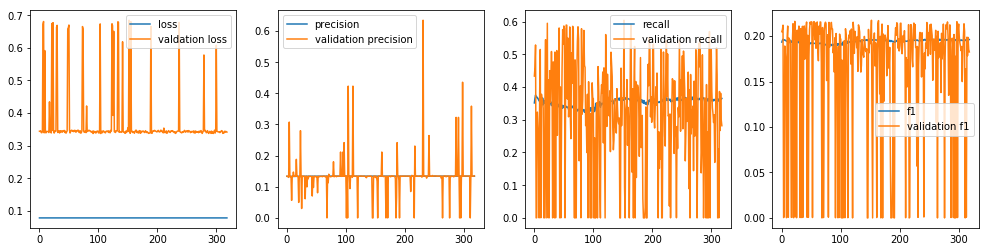

Epoch 320/10000
10223616/15331005 [===================>..........] - ETA: 17s - loss: 0.0782 - f1: 0.1951 - precision: 0.1342 - recall: 0.3576

In [ ]:
classifier.compile(optimizer=optmzr, loss="binary_crossentropy", metrics=[f1,precision,recall])
classifier.fit(X_train, Y_train,
                epochs=10000,
                batch_size=131072,
                shuffle=True,
                validation_data=(X_test, Y_test),
                callbacks=[plot],
                class_weight={0: 0.13, 1: 0.87})

In [7]:
layers = [l for l in classifier.layers]
inputLayer = layers[0]
newHidden = inputLayer.output
for i in range(20):
    newHidden = Dense(bit_count, name="new_Dense"+str(i))(newHidden)
    newHidden = BatchNormalization(name="new_BatchNormalization"+str(i))(newHidden)
    newHidden = Activation("relu", name="new_Activation"+str(i))(newHidden)
for i in range(1, len(layers)):
    #layers[i].trainable = False
    newHidden = layers[i](newHidden)

classifier = Model(input=inputLayer.input, output=newHidden)
classifier.compile(optimizer='adam', loss="mean_squared_error", metrics=[f1,precision,recall])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24)                0         
_________________________________________________________________
new_Dense0 (Dense)           (None, 24)                600       
_________________________________________________________________
new_BatchNormalization0 (Bat (None, 24)                96        
_________________________________________________________________
new_Activation0 (Activation) (None, 24)                0         
_________________________________________________________________
new_Dense1 (Dense)           (None, 24)                600       
_________________________________________________________________
new_BatchNormalization1 (Bat (None, 24)                96        
_________________________________________________________________
new_Activation1 (Activation) (None, 24)                0         
__________

c:\users\edward\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


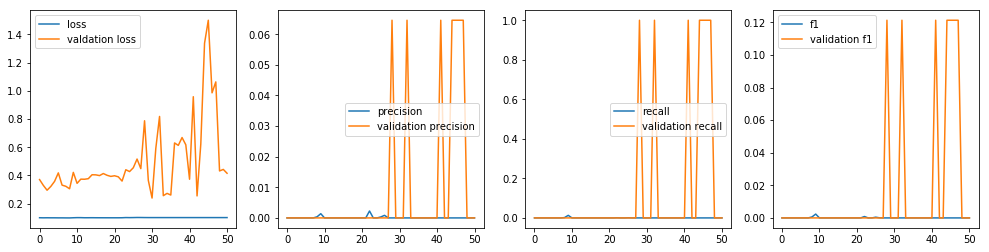

Epoch 52/100
13565952/15331005 [=========================>....] - ETA: 6s - loss: 0.1009 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: 

In [16]:
classifier.compile(optimizer='adam', loss="binary_crossentropy", metrics=[f1,precision,recall])
classifier.fit(X_train, Y_train,
                epochs=100,
                batch_size=65536,
                shuffle=True,
                validation_data=(X_test, Y_test),
                callbacks=[plot],
                class_weight={0: 0.1, 1: 0.9})

In [12]:
layers = [l for l in classifier.layers]
for i in range(len(layers)):
    layers[i].trainable = True
classifier.compile(optimizer='adam', loss="mean_squared_error", metrics=[f1,precision,recall])

In [ ]:
classifier.save("classifier_deeper1")